In [68]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

In [52]:
#read train and test data
train_data = pd.read_excel('训练.xlsx')
test_data_1 = pd.read_excel('测试A.xlsx')
test_data_2 = pd.read_excel('测试B.xlsx')

In [71]:
train_nonnull = train_data.isnull().values
test_nonnull_1 = test_data_1.isnull().values
test_nonnull_2 = test_data_2.isnull().values
train_X = train_data.values
test_X_1 = test_data_1.values
test_X_2 = test_data_2.values
test_id_1 = test_X_1[:, 0]
test_id_2 = test_X_2[:, 0]
train_y = train_X[:, -1]
train_X = train_X[:, 1:-1]
test_X_1 = test_X_1[:, 1:]
test_X_2 = test_X_2[:, 1:]

In [72]:
train_X.shape, test_X_1.shape, test_X_2.shape

((500, 8027), (100, 8027), (121, 8027))

In [73]:
#Merge two data
merged_X = np.concatenate((train_X, test_X_1, test_X_2), axis=0)
merged_nn = np.concatenate((train_nonnull[:, 1:-1], test_nonnull_1[:, 1:], test_nonnull_2[:, 1:]), axis=0)
print(merged_X.shape, merged_nn.shape)

(721, 8027) (721, 8027)


In [74]:
#reverse nn
def BoolReverse(columns):
    tmpm = np.zeros(columns.shape)
    tmpm[columns] = 1
    return tmpm == 0

merged_nn = BoolReverse(merged_nn)

In [75]:
# now find the values that has 0 value and delete such column
first_delete_idxs = []
for i in range(merged_X.shape[1]):
    data = merged_X[:, i]
    real = merged_nn[:, i]
    rd = data[real]
    if len(rd) == 0:
        first_delete_idxs.append(i)
    elif len(set(rd)) == 0:
        first_delete_idxs.append(i)
print(len(first_delete_idxs))

62


In [76]:
print(merged_X.shape)
merged_X = np.delete(merged_X, first_delete_idxs, axis=1)
print(merged_X.shape)

(721, 8027)
(721, 7965)


In [77]:
print(merged_nn.shape)
merged_nn = np.delete(merged_nn, first_delete_idxs, axis=1)
print(merged_nn.shape)

(721, 8027)
(721, 7965)


In [78]:
#now find the columns that has only one value
only_one_values = 0
for i in range(merged_X.shape[1]):
    data = merged_X[:, i]
    real = merged_nn[:, i]
    rd = data[real]
    if len(set(rd)) == 1:
        merged_X[:, i] = 1.0
        merged_nn[:, i] = True
        only_one_values += 1
print(only_one_values)

1007


In [79]:
def dict2list(dic):
    keys = dic.keys()
    vals = dic.values()
    lst = [(key, val) for key, val in zip(keys, vals)]
    return lst

# input one array and return the most frequent one
def MostFrequentOne(column):
    itemfreq = {}
    for i in column:
        if i not in itemfreq:
            itemfreq[i] = 1
        else:
            itemfreq[i] += 1
    tmp_dict = sorted(dict2list(itemfreq), key=lambda d:d[1], reverse=True)
    return tmp_dict[0][0]

In [80]:
# one_hot to map str to int
def OneHot_Str(column, retdict = 0):
    syms = set(column)
    sim = {}
    count = 0
    for s in syms:
        sim[s] = count
        count += 1
    cl = len(column)
    retoh = np.zeros((cl, count))
    for i in range(cl):
        s = column[i]
        mi = sim[s]
        retoh[i, mi] = 1.0
    if retdict == 0:
        return retoh
    else:
        return retoh, sim

In [81]:
#now fix the remain data
#if the values in data has one value that is string, then one_hot it, else normalize it
stridxs = []
intidxs = []
types = []
for i in range(merged_X.shape[1]):
    data = merged_X[:, i]
    real = merged_nn[:, i]
    rd = data[real]
    #if len(data) == len(rd) and np.mean(data) == 1.0:
    #    continue
    isstr = False
    for j in range(len(rd)):
        x = rd[j]
        sx = str(type(x))
        if 'str' in sx:
            isstr = True
            break
    if isstr:
        stridxs.append(i)
        types.append('str')
        # fix null and one_hot it
        if len(rd) < len(data):
            mfc = MostFrequentOne(rd)
            rn = BoolReverse(real)
            data[rn] = mfc
        onehots = OneHot_Str(data)
        merged_X = np.concatenate((merged_X, onehots), axis=1)
    else:
        if 'int' in str(type(rd[0])):
            intidxs.append(i)
            types.append('int')
        else:
            types.append('float')
        
        if len(rd) < len(data):
            if len(set(data)) == 1:
                continue
            rn = BoolReverse(real)
            data[rn] = np.mean(rd)
            mean = np.mean(data)
            std = np.std(data)
            data = (data-mean)/std
            merged_X[:, i] = data
        
# delete the string columns and len_two columns
print(len(stridxs))
print(merged_X.shape)
stridxs += intidxs
merged_X = np.delete(merged_X, stridxs, axis=1)
print(merged_X.shape)
print(len(intidxs))

10
(721, 7999)
(721, 6928)
1061


In [50]:
intnums = {}
for i in intidxs:
    data = merged_X[:, i]
    real = merged_nn[:, i]
    rd = data[real]
    ns = len(set(rd))
    #print(set(rd))
    if ns == 3:
        print(set(rd))
    if ns not in intnums:
        intnums[ns] = 1
    else:
        intnums[ns] += 1
keys = np.sort(list(intnums.keys()))
#print(keys)
sums = 0
for k in keys:
    print(k, intnums[k])
    sums += k
print(sums)

{0, 1, 2}
{0, 2, 3}
{9969, 9994, 9999}
{9969, 9994, 9999}
{0, 1, 3}
{1, 2, 3}
{0, 1, 2}
{8, 13, 15}
{120, 118, 119}
{120, 118, 119}
{120, 118, 119}
{120, 121, 119}
{120, 118, 119}
{120, 121, 119}
{120, 118, 119}
{0, 1, 2}
{120, 118, 119}
{120, 121, 119}
{102, 91, 94}
{4000, 4010, 4020}
{4000, 4010, 4020}
{4000, 4010, 4020}
{1130, 1123, 1127}
{483, 486, 479}
{147, 140, 143}
{1001, 1004, 997}
{1120, 1123, 1116}
{472, 476, 479}
{136, 140, 133}
{1001, 994, 997}
{448, 449, 30}
{376, 374, 375}
{370, 372, 374}
{0, -4, -2}
{3, 4, 5}
{5, 6, 7}
{12000, 18000, 17999}
{0, 2, 4}
{0, 1, -2}
{0, -4, -2}
{1193, 1197, 1190}
{0, 1, 3}
{99, 101, 78}
{120, 114, 118}
{97, 90, 100}
{81, 92, 77}
{99, 101, 78}
{97, 90, 100}
{81, 92, 79}
{3000, 3010, 3020}
{3000, 3010, 3020}
{1200, 1202, 1204}
{0, 2, -2}
{0, 2, -2}
{0, 2, -2}
{0, -4, -2}
{0, -4, -2}
{400, 402, 405}
{800, 802, 805}
{602, 605, 598}
{595, 598, 591}
{1193, 1197, 1190}
{0, 1, -1}
{0, 1, -1}
{0, -3, -1}
{0, -3, -1}
{112, 113, 111}
{112, 113, 111}
{1

In [65]:
import xgboost as xgb
from xgboost import plot_importance

/home/magnusterra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [66]:
params={
    'eta': 0.1,
    'max_depth':5,   
    'min_child_weight':3,
    'gamma':0.1, 
    'lambda':3,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'booster':'gbtree',
    'objective': 'reg:gamma',
    'nthread':4,
    #'scale_pos_weight': 1,
    'seed':1000,
    'silent':1 ,
    #'eval_metric': 'auc'
}

In [82]:
trX, vaX, tr_y, va_y = train_test_split(merged_X[:500], train_y, test_size=0.2, random_state=50)

In [83]:
dtrain = xgb.DMatrix(trX, tr_y)
num_rounds = 400
plst = params.items()
model = xgb.train(plst, dtrain, num_rounds)

In [84]:
dtest = xgb.DMatrix(vaX)
ans = model.predict(dtest)

In [85]:
#Regression by machinr learn
def MSE_np(y, y_pred):
    return np.mean(np.square(y-y_pred))

In [86]:
print(MSE_np(ans, va_y))

0.03961982692299999


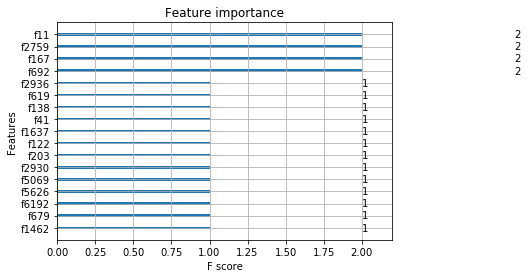

In [87]:
plot_importance(model)
plt.show()

In [88]:
dtrain = xgb.DMatrix(merged_X[:500], train_y)
num_rounds = 400
plst = params.items()
model = xgb.train(plst, dtrain, num_rounds)
ta = model.predict(dtrain)
print(MSE_np(ta, train_y))
dtest = xgb.DMatrix(merged_X[500:600])
test1_pred = model.predict(dtest)
test1_pred = test1_pred.reshape(100)
save = pd.DataFrame({'ID':test_id_1, 'value':test1_pred})
save.to_csv('answer.csv', index=False, header=False)

0.029100139888246303
